## Imports

In [1]:
import data_functions as da
import ml_functions as ml

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
# from simpleloop
from __future__ import division
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pylab as pl
from datetime import timedelta
import random
from scipy import optimize
import time
import seaborn as sns
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
from sklearn import preprocessing, cross_validation, svm, metrics, tree, decomposition, svm
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, Perceptron, SGDClassifier, OrthogonalMatchingPursuit, RandomizedLogisticRegression
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split
from sklearn.grid_search import ParameterGrid
from sklearn.metrics import *
from sklearn.preprocessing import StandardScaler
import itertools
from datetime import datetime
from sklearn.metrics import precision_recall_curve

## Functions

#### See ml_functions.py for additional helper functions

In [3]:
# Magicloop code adapted from Rayid Ghani: https://github.com/rayidghani/magicloops/blob/master/magicloops.py
def LR():
    return LogisticRegression(penalty = 'l1', C = 1e5)

def KNN():
    return KNeighborsClassifier(n_neighbors = 3)

def DT():
    return DecisionTreeClassifier()

def SVM():
    return svm.SVC(kernel = 'linear', probability = True, random_state = 3)

def RF():
    return RandomForestClassifier(n_estimators = 50, n_jobs = -1)

def AB():
    return AdaBoostClassifier(DecisionTreeClassifier(max_depth=1),
                                                    algorithm="SAMME",
                                                    n_estimators=200)
def GB():
    return GradientBoostingClassifier(learning_rate = 0.05,
                                    	subsample = 0.5,
                                    	max_depth = 6,
                                    	n_estimators = 10)
def NB():
    return GaussianNB()

In [4]:
all_models = models_to_run=['RF','DT','KNN', 'ET', 'AB', 'GB', 'LR', 'NB']

def classifier_loop(df, features, start, grid_size='test', models_to_run = all_models):
    '''
    Runs all classifiers for a selected time range
    
    Inputs:
        df (pandas dataframe): data frame containing data to be classified
        features (list): list of features to use for classification
        start (string): start date
        grid_size (str): grid size
        models_to_run (list): list of models that should be run
        
    Output:
        results_df (pandas dataframe): dataframe containing results and evaluation for all models 
    '''
    
    # define grid to use: test, small, large
    clfs, grid = define_clfs_params(grid_size)
    
    X_test, X_train, y_test, y_train = train_test_over_time(df, features, start=start)
    # call clf_loop and store results in results_df
    results_df = ml.my_loop(models_to_run, clfs,grid, X_test, X_train, y_test, y_train)
    
    return results_df

In [25]:
# Magicloop code from Rayid Ghani: https://github.com/rayidghani/magicloops/blob/master/magicloops.py

def define_clfs_params(grid_size):
    """Define defaults for different classifiers.
    Define three types of grids:
    Test: for testing your code
    Small: small grid
    Large: Larger grid that has a lot more parameter sweeps
    """

    clfs = {'RF': RandomForestClassifier(n_estimators=50, n_jobs=-1),
        'ET': ExtraTreesClassifier(n_estimators=10, n_jobs=-1, criterion='entropy'),
        'AB': AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), algorithm="SAMME", n_estimators=200),
        'LR': LogisticRegression(penalty='l1', C=1e5),
        'SVM': svm.SVC(kernel='linear', probability=True, random_state=0),
        'GB': GradientBoostingClassifier(learning_rate=0.05, subsample=0.5, max_depth=6, n_estimators=10),
        'NB': GaussianNB(),
        'DT': DecisionTreeClassifier(),
        'SGD': SGDClassifier(loss="hinge", penalty="l2"),
        'KNN': KNeighborsClassifier(n_neighbors=3) 
            }

    large_grid = { 
    'RF':{'n_estimators': [1,10,100,1000,10000], 'max_depth': [1,5,10,20,50,100], 'max_features': ['sqrt','log2'],'min_samples_split': [2,5,10], 'n_jobs': [-1]},
    'LR': { 'penalty': ['l1','l2'], 'C': [0.00001,0.0001,0.001,0.01,0.1,1,10]},
    'SGD': { 'loss': ['hinge','log','perceptron'], 'penalty': ['l2','l1','elasticnet']},
    'ET': { 'n_estimators': [1,10,100,1000,10000], 'criterion' : ['gini', 'entropy'] ,'max_depth': [1,5,10,20,50,100], 'max_features': ['sqrt','log2'],'min_samples_split': [2,5,10], 'n_jobs': [-1]},
    'AB': { 'algorithm': ['SAMME', 'SAMME.R'], 'n_estimators': [1,10,100,1000,10000]},
    'GB': {'n_estimators': [1,10,100,1000,10000], 'learning_rate' : [0.001,0.01,0.05,0.1,0.5],'subsample' : [0.1,0.5,1.0], 'max_depth': [1,3,5,10,20,50,100]},
    'NB' : {},
    'DT': {'criterion': ['gini', 'entropy'], 'max_depth': [1,5,10,20,50,100],'min_samples_split': [2,5,10]},
    'SVM' :{'C' :[0.00001,0.0001,0.001,0.01,0.1,1,10],'kernel':['linear']},
    'KNN' :{'n_neighbors': [1,5,10,25,50,100],'weights': ['uniform','distance'],'algorithm': ['auto','ball_tree','kd_tree']}
           }
    
    small_grid = { 
    'RF':{'n_estimators': [10,100], 'max_depth': [5,50], 'max_features': ['sqrt','log2'],'min_samples_split': [2,10], 'n_jobs': [-1]},
    'LR': { 'penalty': ['l1','l2'], 'C': [0.00001,0.001,0.1,1,10]},
    'SGD': { 'loss': ['hinge','log','perceptron'], 'penalty': ['l2','l1','elasticnet']},
    'ET': { 'n_estimators': [10,100], 'criterion' : ['gini', 'entropy'] ,'max_depth': [5,50], 'max_features': ['sqrt','log2'],'min_samples_split': [2,10], 'n_jobs': [-1]},
    'AB': { 'algorithm': ['SAMME', 'SAMME.R'], 'n_estimators': [1,10,100,1000,10000]},
    'GB': {'n_estimators': [10,100], 'learning_rate' : [0.001,0.1,0.5],'subsample' : [0.1,0.5,1.0], 'max_depth': [5,50]},
    'NB' : {},
    'DT': {'criterion': ['gini', 'entropy'], 'max_depth': [1,5,10,20,50,100],'min_samples_split': [2,5,10]},
    'SVM' :{'C' :[0.00001,0.0001,0.001,0.01,0.1,1,10],'kernel':['linear']},
    'KNN' :{'n_neighbors': [1,5,10,25,50,100],'weights': ['uniform','distance'],'algorithm': ['auto','ball_tree','kd_tree']}
           }
    
    test_grid = { 
    'RF':{'n_estimators': [1], 'max_depth': [1], 'max_features': ['sqrt'],'min_samples_split': [10]},
    'LR': { 'penalty': ['l1'], 'C': [0.01]},
    'SGD': { 'loss': ['perceptron'], 'penalty': ['l2']},
    'ET': { 'n_estimators': [1], 'criterion' : ['gini'] ,'max_depth': [1], 'max_features': ['sqrt'],'min_samples_split': [10]},
    'AB': { 'algorithm': ['SAMME'], 'n_estimators': [1]},
    'GB': {'n_estimators': [1], 'learning_rate' : [0.1],'subsample' : [0.5], 'max_depth': [1]},
    'NB' : {},
    'DT': {'criterion': ['gini'], 'max_depth': [1],'min_samples_split': [10]},
    'SVM' :{'C' :[0.01],'kernel':['linear']},
    'KNN' :{'n_neighbors': [5],'weights': ['uniform'],'algorithm': ['auto']}
           }
    
    if (grid_size == 'large'):
        return clfs, large_grid
    elif (grid_size == 'small'):
        return clfs, small_grid
    elif (grid_size == 'test'):
        return clfs, test_grid
    else:
        return 0, 0

In [27]:
def train_test_over_time(df, features, target='fully_funded', start='Jan 2011'):
    '''
    Creates train/test sets for a given time period. 
    '''
    dates = {}
    dates['2011-01-01'] = ['2011-12-31', '2012-06-31']
    dates['2011-07-01'] = ['2012-07-31', '2012-12-31']
    dates['2012-01-01'] = ['2012-12-31', '2013-06-31']

    if start == 'Jan 2011':
        start = '2011-01-01'
        end_train = dates[start][0]
        end_test = dates[start][1]
    elif start == 'Jul 2011':
        start = '2011-07-01'
        end_train = dates[start][0]
        end_test = dates[start][1]
    elif start == 'Jan 2012':
        start = '2012-01-01'
        end_train = dates[start][0]
        end_test = dates[start][1]
    
        
    x_test = da.specify_range(df, 'date_posted', start, end_train)
    x_train = da.specify_range(df, 'date_posted', end_train, end_test)
    x_test, x_train = x_test[features], x_train[features]

    y_test = da.specify_range(df[['date_posted', target]], 'date_posted', start, end_train)
    y_train = da.specify_range(df[['date_posted', target]], 'date_posted', end_train, end_test)
    y_test, y_train = y_test[target], y_train[target]
                         
    return x_test, x_train, y_test, y_train

In [53]:
def my_loop(models_to_run, clfs, grid, X_train, X_test, y_train, y_test, NOTEBOOK = 1, output_type='show'):
    """Runs the loop using models_to_run, clfs, gridm and the data
    """
    results_df =  pd.DataFrame(columns=('model_type','clf', 'parameters', 'auc-roc','baseline','p_at_1', 'p_at_2','p_at_5', 'p_at_10', 'p_at_20', 'p_at_30','p_at_50', 
                                        'r_at_1',
                                        'r_at_2', 'r_at_5',
                                        'r_at_10', 'r_at_20','r_at_30',
                                        'r_at_50', 'f1_at_2', 'f1_at_20', 'f1_at_50'))
    for n in range(1, 2):
        # create training and valdation sets
        for index,clf in enumerate([clfs[x] for x in models_to_run]):
            print(models_to_run[index])
            parameter_values = grid[models_to_run[index]]
            for p in ParameterGrid(parameter_values):
                try:
                    clf.set_params(**p)
                    y_pred_probs = clf.fit(X_train, y_train).predict_proba(X_test)[:,1]
                    plot_precision_recall_n(y_test.ravel(),np.asarray(y_pred_probs).ravel(), clf, output_type)
                    # you can also store the model, feature importances, and prediction scores
                    # we're only storing the metrics for now
                    y_pred_probs_sorted, y_test_sorted = zip(*sorted(zip(y_pred_probs, y_test), reverse=True))
                    p2 = precision_at_k(y_test_sorted,y_pred_probs_sorted,2.0)
                    r2 = recall_at_k(y_test_sorted,y_pred_probs_sorted,2.0)
                    p20 = precision_at_k(y_test_sorted,y_pred_probs_sorted,20.0)
                    r20 = recall_at_k(y_test_sorted,y_pred_probs_sorted,20.0)
                    p50 = precision_at_k(y_test_sorted,y_pred_probs_sorted,50.0)
                    r50 = recall_at_k(y_test_sorted,y_pred_probs_sorted,50.0)
                    results_df.loc[len(results_df)] = [models_to_run[index],clf, p,
                                                       roc_auc_score(y_test, y_pred_probs),
                                                       precision_at_k(y_test_sorted, y_pred_probs_sorted, 100),
                                                       precision_at_k(y_test_sorted,y_pred_probs_sorted,1.0),
                                                       p2,
                                                       precision_at_k(y_test_sorted,y_pred_probs_sorted,5.0),
                                                       precision_at_k(y_test_sorted,y_pred_probs_sorted,10.0),
                                                       p20,
                                                       precision_at_k(y_test_sorted,y_pred_probs_sorted,30.0),
                                                       p50,
                                                      recall_at_k(y_test_sorted,y_pred_probs_sorted,1.0),
                                                       r2,
                                                       recall_at_k(y_test_sorted,y_pred_probs_sorted,5.0),
                                                       recall_at_k(y_test_sorted,y_pred_probs_sorted,10.0),
                                                       r20,
                                                       recall_at_k(y_test_sorted,y_pred_probs_sorted,30.0),
                                                       r50,
                                                        2*(p2*r2)/(p2 + r2),
                                                           2*(p20*r20)/(p20 + r20),
                                                           2*(p50*r50)/(p50 + r50)]


                    if NOTEBOOK == 1:
                        plot_precision_recall_n(y_test,y_pred_probs,clf)
                except IndexError as e:
                    print('Error:',e)
                    continue
    return results_df


In [ ]:
def joint_sort_descending(l1, l2):
    # l1 and l2 have to be numpy arrays
    idx = np.argsort(l1)[::-1]
    return l1[idx], l2[idx]

def precision_at_k(y_true, y_scores, k):
    y_scores, y_true = joint_sort_descending(np.array(y_scores), np.array(y_true))
    preds_at_k = generate_binary_at_k(y_scores, k)
    #precision, _, _, _ = metrics.precision_recall_fscore_support(y_true, preds_at_k)
    #precision = precision[1]  # only interested in precision for label 1
    precision = precision_score(y_true, preds_at_k)
    return precision

def generate_binary_at_k(y_scores, k):
    cutoff_index = int(len(y_scores) * (k / 100.0))
    predictions_binary = [1 if x < cutoff_index else 0 for x in range(len(y_scores))]
    return predictions_binary

def recall_at_k(y_true, y_scores, k):
    #y_scores_sorted, y_true_sorted = zip(*sorted(zip(y_scores, y_true), reverse=True))
    y_scores_sorted, y_true_sorted = joint_sort_descending(np.array(y_scores), np.array(y_true))
    preds_at_k = generate_binary_at_k(y_scores_sorted, k)
    #precision, _, _, _ = metrics.precision_recall_fscore_support(y_true, preds_at_k)
    #precision = precision[1]  # only interested in precision for label 1
    recall = recall_score(y_true_sorted, preds_at_k)
    return recall

def plot_precision_recall_n(y_true, y_prob, model_name, output_type):
    from sklearn.metrics import precision_recall_curve
    y_score = y_prob
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_score)
    precision_curve = precision_curve[:-1]
    recall_curve = recall_curve[:-1]
    pct_above_per_thresh = []
    number_scored = len(y_score)
    for value in pr_thresholds:
        num_above_thresh = len(y_score[y_score>=value])
        pct_above_thresh = num_above_thresh / float(number_scored)
        pct_above_per_thresh.append(pct_above_thresh)
    pct_above_per_thresh = np.array(pct_above_per_thresh)
    
    plt.clf()
    fig, ax1 = plt.subplots()
    ax1.plot(pct_above_per_thresh, precision_curve, 'b')
    ax1.set_xlabel('percent of population')
    ax1.set_ylabel('precision', color='b')
    ax2 = ax1.twinx()
    ax2.plot(pct_above_per_thresh, recall_curve, 'r')
    ax2.set_ylabel('recall', color='r')
    ax1.set_ylim([0,1])
    ax1.set_ylim([0,1])
    ax2.set_xlim([0,1])
    
    name = model_name
    plt.title(name)
    if (output_type == 'save'):
        plt.savefig(name)
    elif (output_type == 'show'):
        plt.show()
    else:
        plt.show()


# Other helper functions

def get_subsets(l):
    subsets = []
    for i in range(1, len(l) + 1):
        for combo in itertools.combinations(l, i):
            subsets.append(list(combo))
    return subsets

def joint_sort_descending(l1, l2):
    # l1 and l2 have to be numpy arrays
    idx = np.argsort(l1)[::-1]
    return l1[idx], l2[idx]


In [50]:
def add_dummy_for_discretized(df, col, num_disc_cats, label):
    ml.add_discrete_variable(df, col, 'temp_disc', num_disc_cats)
    temp = pd.get_dummies(classify['temp_disc'])
    tc = []
    for c in temp.columns:
        tc.append(label + str(c))
    temp.columns = tc
    df = df.join(temp)
    #df = df.drop(col, axis=1)
    #df = df.drop('temp_disc', axis=1) 
    
    return df

In [ ]:
def classifier_loop(df, features, start, grid_size='test', models_to_run = models_to_run):
    
    # define grid to use: test, small, large
    clfs, grid = define_clfs_params(grid_size)
    
    X_test, X_train, y_test, y_train = train_test_over_time(df, features, start=start)
    # call clf_loop and store results in results_df
    results_df = my_loop(models_to_run, clfs,grid, X_test, X_train, y_test, y_train, NOTEBOOK=0)
    
    return results_df

In [ ]:
def plot_precision_recall(df, features, start, classifier, title=''
, color='b'):
    X_test, X_train, y_test, y_train = train_test_over_time(df, features, start='Jan 2011')
    random_state = np.random.RandomState(0)
    classifier = classifier
    classifier.fit(X_train, y_train)
    y_score = classifier.decision_function(X_test)
    
    precision, recall, _ = precision_recall_curve(y_test, y_score)

    plt.step(recall, precision, color=color, alpha=0.2, where='post')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(title)
    plt.show()

In [ ]:
def graph_selected(df, features, models, dates):
    for d in dates:
        for m in models:
            print(d)
            print(m)
            plot_precision_recall(df, features, d, m)

## Formatting for classification

In [9]:
# to load
all_projects = da.read_data('projects.csv')
outcomes = da.read_data('outcomes.csv')

projects = da.specify_range(all_projects, 'date_posted', '2011-01-01', '2013-12-31')
combined = pd.merge(projects, outcomes, on='projectid')
funded = combined.loc[combined.fully_funded=='t']
unfunded = combined.loc[combined.fully_funded=='f']

Outliers were removed for the three numerical columns. 

In [10]:
da.replace_na(combined, 'students_reached')
inf = ['total_price_excluding_optional_support', 'total_price_including_optional_support', 'students_reached']
for i in inf:
    combined = da.remove_outliers(combined, i)

In [11]:
projects.columns

Index(['projectid', 'teacher_acctid', 'schoolid', 'school_ncesid',
       'school_latitude', 'school_longitude', 'school_city', 'school_state',
       'school_zip', 'school_metro', 'school_district', 'school_county',
       'school_charter', 'school_magnet', 'school_year_round', 'school_nlns',
       'school_kipp', 'school_charter_ready_promise', 'teacher_prefix',
       'teacher_teach_for_america', 'teacher_ny_teaching_fellow',
       'primary_focus_subject', 'primary_focus_area',
       'secondary_focus_subject', 'secondary_focus_area', 'resource_type',
       'poverty_level', 'grade_level', 'fulfillment_labor_materials',
       'total_price_excluding_optional_support',
       'total_price_including_optional_support', 'students_reached',
       'eligible_double_your_impact_match', 'eligible_almost_home_match',
       'date_posted'],
      dtype='object')

In [12]:
classify = combined[['projectid', 'teacher_acctid', 'schoolid', 'school_ncesid',
       'school_latitude', 'school_longitude', 'school_city', 'school_state',
       'school_zip', 'school_metro', 'school_district', 'school_county',
       'school_charter', 'school_magnet', 'school_year_round', 'school_nlns',
       'school_kipp', 'school_charter_ready_promise', 'teacher_prefix',
       'teacher_teach_for_america', 'teacher_ny_teaching_fellow',
       'primary_focus_subject', 'primary_focus_area',
       'secondary_focus_subject', 'secondary_focus_area', 'resource_type',
       'poverty_level', 'grade_level', 'fulfillment_labor_materials',
       'total_price_excluding_optional_support',
       'total_price_including_optional_support', 'students_reached',
       'eligible_double_your_impact_match', 'eligible_almost_home_match',
       'date_posted','fully_funded']]
# projects + fully funded 

y = combined[['date_posted', 'fully_funded']]

Binary columns were found and turned into dummy variables. 

In [13]:
b = ml.find_binary_cols(classify)

In [14]:
#b.remove('eligible_double_your_impact_match')
ml.turn_to_1_0(classify, b)    
classify['eligible_double_your_impact_match'] = classify['eligible_double_your_impact_match'].apply(lambda x: 1 if x=='t' else 0)

/Users/natasha/MachineLearning2018/Homework3/ml_functions.py:443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df[col] = df[col].apply(lambda x: 1 if x=='t' else 0)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [15]:
cats = [x for x in classify.columns if x not in b]   
cats = ['school_metro', 'teacher_prefix', 'primary_focus_area', 'resource_type', 'poverty_level', 'grade_level']

In [16]:
classify = ml.category_cols(classify, cats)

The three numerical variables were discretized and further turned into dummy variables. 

In [19]:
classify = add_dummy_for_discretized(classify, 'students_reached', 5, ' students reached ')
classify = add_dummy_for_discretized(classify, 'total_price_excluding_optional_support', 10, ' price ex ')
classify = add_dummy_for_discretized(classify, 'total_price_including_optional_support', 10, ' price inc ')

In [20]:
features = [ 'school_charter',
       'school_magnet', 'school_year_round', 'school_nlns', 'school_kipp',
       'school_charter_ready_promise', 'teacher_teach_for_america',
       'teacher_ny_teaching_fellow', 
       'fulfillment_labor_materials', 'total_price_excluding_optional_support',
       'total_price_including_optional_support', 'students_reached',
       'eligible_double_your_impact_match', 'eligible_almost_home_match',
         'rural', 'suburban', 'urban', 'Dr.',
       'Mr.', 'Mrs.', 'Ms.', 'Applied Learning', 'Health & Sports',
       'History & Civics', 'Literacy & Language', 'Math & Science',
       'Music & The Arts', 'Special Needs', 'Books', 'Other', 'Supplies',
       'Technology', 'Trips', 'Visitors', 'high poverty', 'highest poverty',
       'low poverty', 'moderate poverty', 'Grades 3-5', 'Grades 6-8',
       'Grades 9-12', 'Grades PreK-2']

In [21]:
features2 = features + ['(0.454, 110.2]',
       '(110.2, 219.4]', '(219.4, 328.6]', '(328.6, 437.8]', '(437.8, 547.0]',
       'students reached (0.454, 110.2]', 'students reached (110.2, 219.4]',
       'students reached (219.4, 328.6]', 'students reached (328.6, 437.8]',
       'students reached (437.8, 547.0]'] + [' price ex (184.457, 331.884]', ' price ex (331.884, 479.311]',
       ' price ex (479.311, 626.738]', ' price ex (626.738, 774.165]',
       ' price ex (774.165, 921.592]', ' price ex (921.592, 1069.019]',
       ' price ex (1069.019, 1216.446]', ' price ex (1216.446, 1363.873]',
       ' price ex (1363.873, 1511.3]', ' price inc (41.826, 217.004]',
       ' price inc (217.004, 390.448]', ' price inc (390.448, 563.892]',
       ' price inc (563.892, 737.336]', ' price inc (737.336, 910.78]',
       ' price inc (910.78, 1084.224]', ' price inc (1084.224, 1257.668]',
       ' price inc (1257.668, 1431.112]', ' price inc (1431.112, 1604.556]',
       ' price inc (1604.556, 1778.0]']

### Dates Used

#### dates[start] = [end_train, end_test]
#### dates['2011-01-01'] = ['2011-12-31', '2012-06-31'] - Jan 2011
#### dates['2011-07-01'] = ['2012-07-31', '2012-12-31'] - Jul 2011
#### dates['2012-01-01'] = ['2012-12-31', '2013-06-31'] - Jan 2012

Each date range was classified separately to optimize the presentation of data. 

RF


<Figure size 432x288 with 0 Axes>

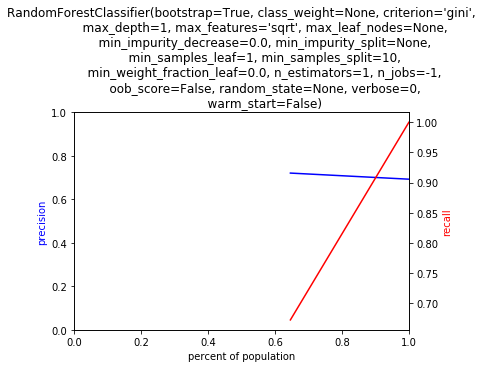

DT


<Figure size 432x288 with 0 Axes>

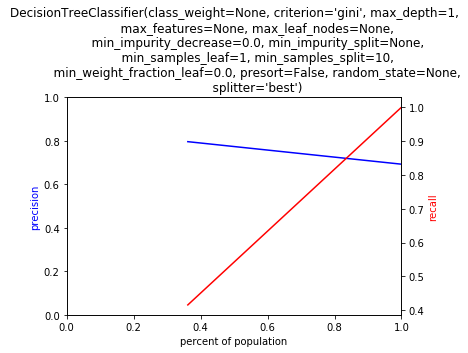

KNN


<Figure size 432x288 with 0 Axes>

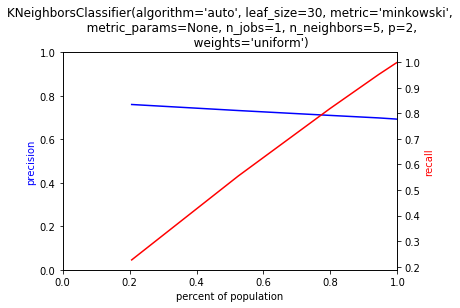

ET


<Figure size 432x288 with 0 Axes>

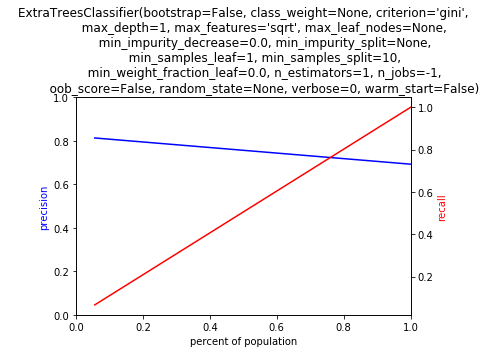

AB


<Figure size 432x288 with 0 Axes>

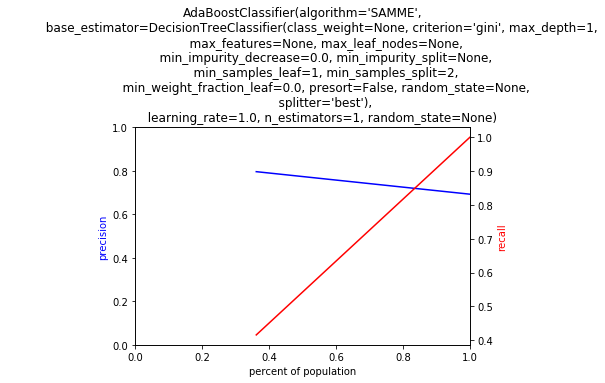

GB


<Figure size 432x288 with 0 Axes>

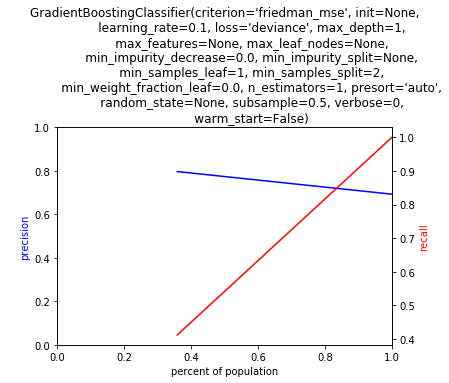

LR


<Figure size 432x288 with 0 Axes>

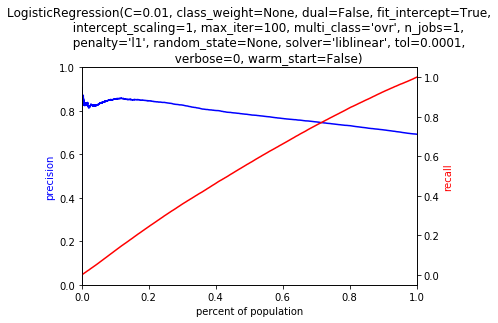

NB


<Figure size 432x288 with 0 Axes>

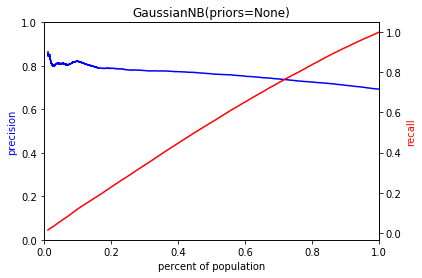

,model_type,clf,parameters,auc-roc,baseline,p_at_1,p_at_2,p_at_5,p_at_10,p_at_20,...,r_at_1,r_at_2,r_at_5,r_at_10,r_at_20,r_at_30,r_at_50,f1_at_2,f1_at_20,f1_at_50
0,RF,"(DecisionTreeClassifier(class_weight=None, cri...","{'max_depth': 1, 'max_features': 'sqrt', 'min_...",0.542599,0.692669,0.997992,0.998997,0.999599,0.999799,0.828202,...,0.014392,0.028842,0.072134,0.144326,0.239134,0.383459,0.672169,0.056065,0.371113,0.780760
1,DT,"DecisionTreeClassifier(class_weight=None, crit...","{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.588031,0.692669,1.000000,1.000000,1.000000,0.905115,0.631331,...,0.014421,0.028871,0.072163,0.130658,0.182289,0.326644,0.615382,0.056122,0.282896,0.714800
2,KNN,"KNeighborsClassifier(algorithm='auto', leaf_si...","{'algorithm': 'auto', 'n_neighbors': 5, 'weigh...",0.562579,0.692669,1.000000,1.000000,1.000000,0.536810,0.752683,...,0.014421,0.028871,0.072163,0.077491,0.217328,0.332436,0.554600,0.056122,0.337273,0.644198
3,ET,"(ExtraTreeClassifier(class_weight=None, criter...","{'criterion': 'gini', 'max_depth': 1, 'max_fea...",0.515902,0.692669,1.000000,0.704112,0.790128,0.895085,0.947548,...,0.014421,0.020328,0.057018,0.129210,0.273593,0.417948,0.706686,0.039516,0.424591,0.820854
4,AB,"(DecisionTreeClassifier(class_weight=None, cri...","{'algorithm': 'SAMME', 'n_estimators': 1}",0.588031,0.692669,1.000000,1.000000,1.000000,0.905115,0.631331,...,0.014421,0.028871,0.072163,0.130658,0.182289,0.326644,0.615382,0.056122,0.282896,0.714800
5,GB,([DecisionTreeRegressor(criterion='friedman_ms...,"{'learning_rate': 0.1, 'max_depth': 1, 'n_esti...",0.587628,0.692669,1.000000,1.000000,1.000000,0.897292,0.635342,...,0.014421,0.028871,0.072163,0.129528,0.183448,0.327802,0.616541,0.056122,0.284694,0.716145
6,LR,"LogisticRegression(C=0.01, class_weight=None, ...","{'C': 0.01, 'penalty': 'l1'}",0.645071,0.692669,0.835341,0.817452,0.829856,0.854363,0.845953,...,0.012046,0.023601,0.059885,0.123331,0.244259,0.358005,0.564909,0.045877,0.379067,0.656172
7,NB,GaussianNB(priors=None),{},0.612108,0.692669,0.841365,0.820461,0.808587,0.821264,0.788587,...,0.012133,0.023687,0.058350,0.118553,0.227695,0.337098,0.550922,0.046046,0.353361,0.639926


In [56]:
classifier_loop(classify, features, 'Jan 2011')

RF


<Figure size 432x288 with 0 Axes>

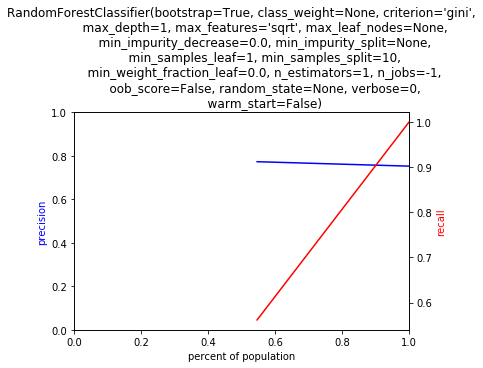

DT


<Figure size 432x288 with 0 Axes>

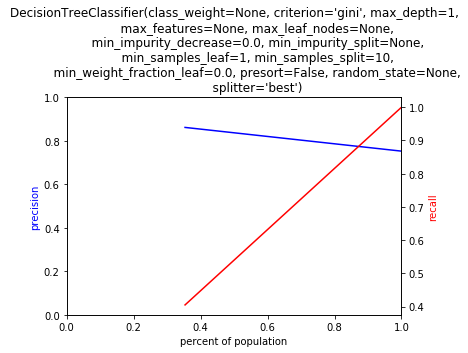

KNN


<Figure size 432x288 with 0 Axes>

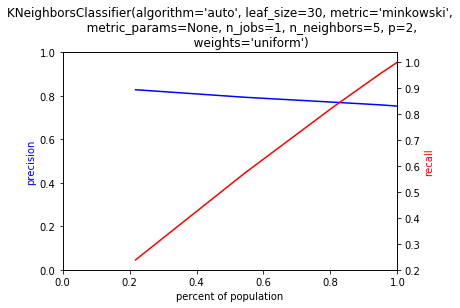

ET


<Figure size 432x288 with 0 Axes>

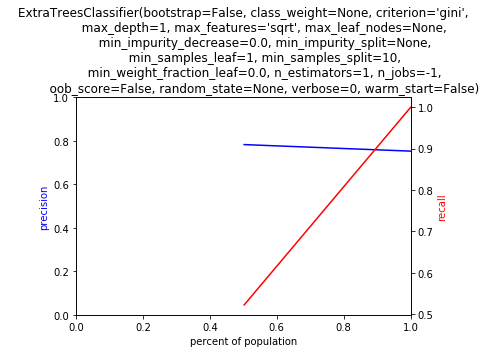

AB


<Figure size 432x288 with 0 Axes>

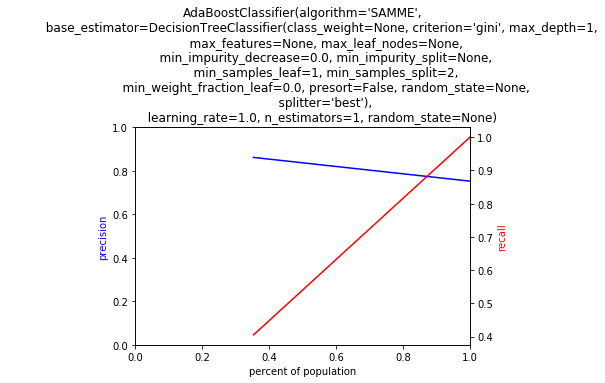

GB


<Figure size 432x288 with 0 Axes>

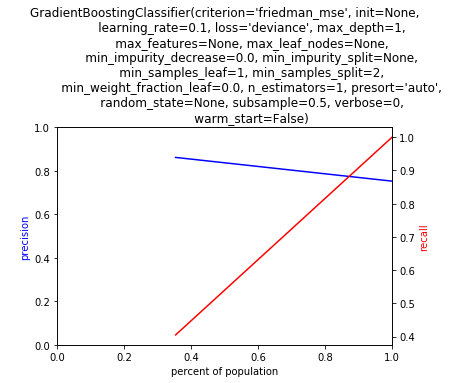

LR


<Figure size 432x288 with 0 Axes>

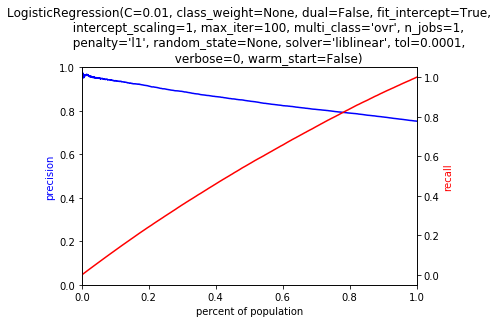

NB


<Figure size 432x288 with 0 Axes>

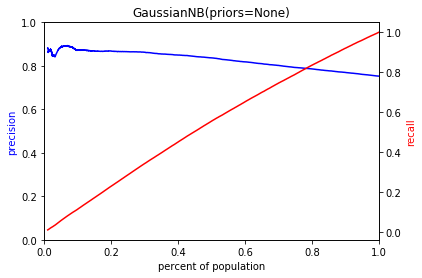

,model_type,clf,parameters,auc-roc,baseline,p_at_1,p_at_2,p_at_5,p_at_10,p_at_20,...,r_at_1,r_at_2,r_at_5,r_at_10,r_at_20,r_at_30,r_at_50,f1_at_2,f1_at_20,f1_at_50
0,RF,"(DecisionTreeClassifier(class_weight=None, cri...","{'max_depth': 1, 'max_features': 'sqrt', 'min_...",0.529939,0.752681,0.998195,0.999098,0.999640,0.999820,0.687455,...,0.013242,0.026532,0.066402,0.132827,0.182658,0.295683,0.561385,0.051691,0.288628,0.674628
1,DT,"DecisionTreeClassifier(class_weight=None, crit...","{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.603594,0.752681,1.000000,1.000000,1.000000,0.884463,0.755588,...,0.013266,0.026556,0.066426,0.117502,0.200761,0.333613,0.599339,0.051738,0.317233,0.720238
2,KNN,"KNeighborsClassifier(algorithm='auto', leaf_si...","{'algorithm': 'auto', 'n_neighbors': 5, 'weigh...",0.578157,0.752681,1.000000,1.000000,1.000000,0.680786,0.812996,...,0.013266,0.026556,0.066426,0.090443,0.216015,0.337085,0.574124,0.051738,0.341336,0.689937
3,ET,"(ExtraTreeClassifier(class_weight=None, criter...","{'criterion': 'gini', 'max_depth': 1, 'max_fea...",0.540640,0.752681,0.998195,0.999098,0.999640,0.999820,0.639059,...,0.013242,0.026532,0.066402,0.132827,0.169800,0.256962,0.522665,0.051691,0.268309,0.628097
4,AB,"(DecisionTreeClassifier(class_weight=None, cri...","{'algorithm': 'SAMME', 'n_estimators': 1}",0.603594,0.752681,1.000000,1.000000,1.000000,0.884463,0.755588,...,0.013266,0.026556,0.066426,0.117502,0.200761,0.333613,0.599339,0.051738,0.317233,0.720238
5,GB,([DecisionTreeRegressor(criterion='friedman_ms...,"{'learning_rate': 0.1, 'max_depth': 1, 'n_esti...",0.603582,0.752681,1.000000,1.000000,1.000000,0.884463,0.755588,...,0.013266,0.026556,0.066426,0.117502,0.200761,0.333613,0.599339,0.051738,0.317233,0.720238
6,LR,"LogisticRegression(C=0.01, class_weight=None, ...","{'C': 0.01, 'penalty': 'l1'}",0.668593,0.752681,0.962094,0.962128,0.950613,0.938717,0.914203,...,0.012763,0.025550,0.063145,0.124710,0.242906,0.354350,0.561433,0.049778,0.383828,0.674686
7,NB,GaussianNB(priors=None),{},0.642598,0.752681,0.871841,0.872858,0.886806,0.871846,0.868151,...,0.011566,0.023180,0.058907,0.115826,0.230670,0.343790,0.555854,0.045160,0.364493,0.667981


In [58]:
classifier_loop(classify, features, 'Jul 2011')

RF


<Figure size 432x288 with 0 Axes>

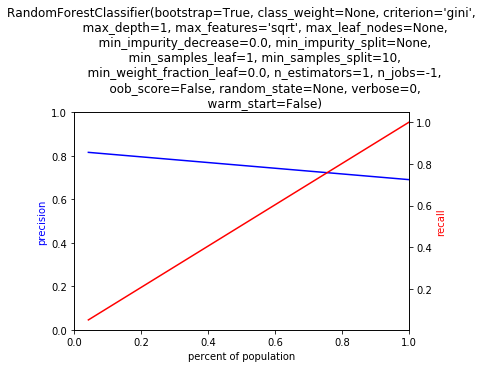

DT


<Figure size 432x288 with 0 Axes>

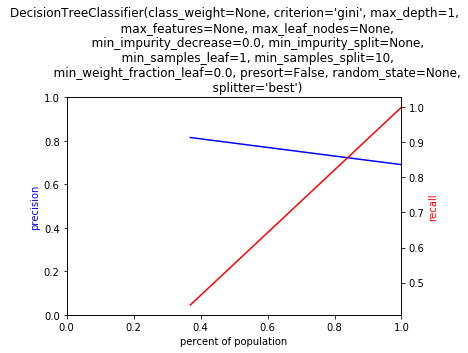

KNN


<Figure size 432x288 with 0 Axes>

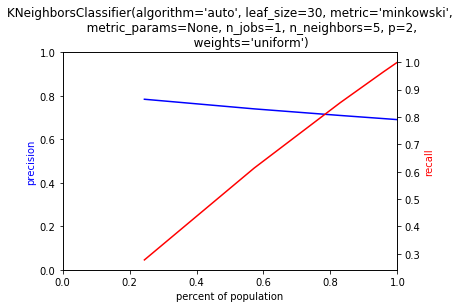

ET


<Figure size 432x288 with 0 Axes>

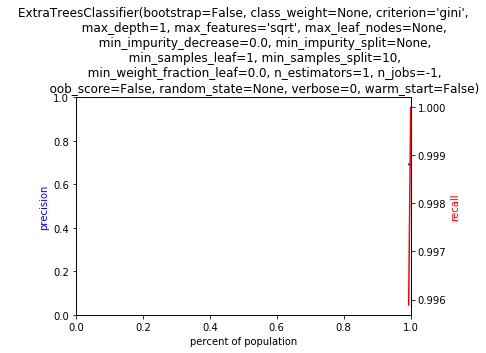

AB


<Figure size 432x288 with 0 Axes>

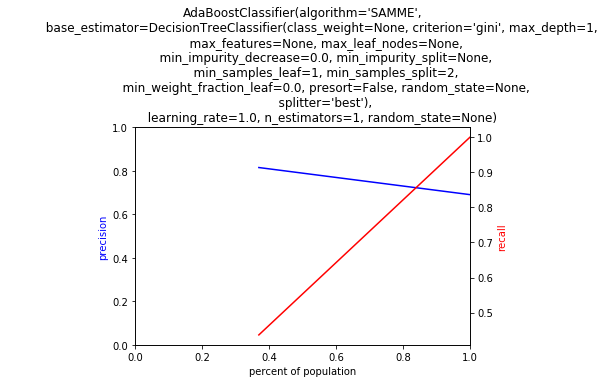

GB


<Figure size 432x288 with 0 Axes>

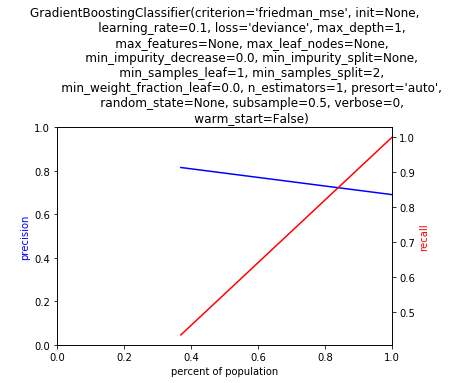

LR


<Figure size 432x288 with 0 Axes>

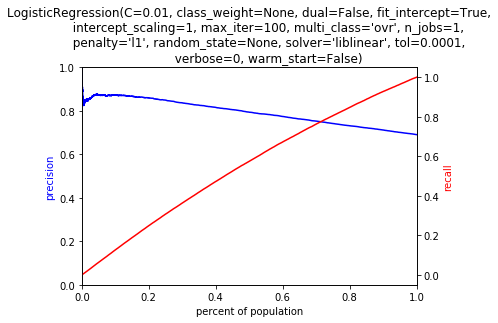

NB


<Figure size 432x288 with 0 Axes>

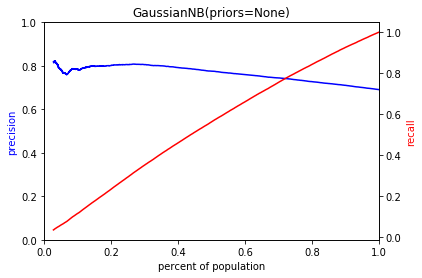

,model_type,clf,parameters,auc-roc,baseline,p_at_1,p_at_2,p_at_5,p_at_10,p_at_20,...,r_at_1,r_at_2,r_at_5,r_at_10,r_at_20,r_at_30,r_at_50,f1_at_2,f1_at_20,f1_at_50
0,RF,"(DecisionTreeClassifier(class_weight=None, cri...","{'max_depth': 1, 'max_features': 'sqrt', 'min_...",0.512507,0.690643,1.000000,0.669903,0.843204,0.921602,0.960806,...,0.014476,0.019396,0.061033,0.133415,0.278215,0.423015,0.712579,0.037700,0.431487,0.826675
1,DT,"DecisionTreeClassifier(class_weight=None, crit...","{'criterion': 'gini', 'max_depth': 1, 'min_sam...",0.607760,0.690643,1.000000,1.000000,1.000000,0.924515,0.658537,...,0.014476,0.028953,0.072382,0.133837,0.190689,0.335488,0.625053,0.056276,0.295741,0.725135
2,KNN,"KNeighborsClassifier(algorithm='auto', leaf_si...","{'algorithm': 'auto', 'n_neighbors': 5, 'weigh...",0.585563,0.690643,1.000000,1.000000,1.000000,0.625728,0.736561,...,0.014476,0.028953,0.072382,0.090583,0.213282,0.358082,0.613176,0.056276,0.330781,0.711357
3,ET,"(ExtraTreeClassifier(class_weight=None, criter...","{'criterion': 'gini', 'max_depth': 1, 'max_fea...",0.503200,0.690643,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.014476,0.028953,0.072382,0.144765,0.289564,0.434364,0.723963,0.056276,0.449089,0.839883
4,AB,"(DecisionTreeClassifier(class_weight=None, cri...","{'algorithm': 'SAMME', 'n_estimators': 1}",0.607760,0.690643,1.000000,1.000000,1.000000,0.924515,0.658537,...,0.014476,0.028953,0.072382,0.133837,0.190689,0.335488,0.625053,0.056276,0.295741,0.725135
5,GB,([DecisionTreeRegressor(criterion='friedman_ms...,"{'learning_rate': 0.1, 'max_depth': 1, 'n_esti...",0.607798,0.690643,1.000000,1.000000,1.000000,0.923786,0.659143,...,0.014476,0.028953,0.072382,0.133732,0.190864,0.335664,0.625228,0.056276,0.296014,0.725338
6,LR,"LogisticRegression(C=0.01, class_weight=None, ...","{'C': 0.01, 'penalty': 'l1'}",0.661849,0.690643,0.844660,0.850728,0.872816,0.872330,0.860211,...,0.012228,0.024631,0.063176,0.126283,0.249086,0.363528,0.574736,0.047876,0.386311,0.666762
7,NB,GaussianNB(priors=None),{},0.630188,0.690643,0.706311,0.746359,0.782039,0.784951,0.801844,...,0.010225,0.021609,0.056606,0.113633,0.232186,0.349859,0.561560,0.042002,0.360099,0.651476


In [57]:
classifier_loop(classify, features, 'Jan 2012')